| **Chapter**                   | 2:  Simple compartmental models                       |
| ----------------------------- | ----------------------------------------------------- |
| **Computational Note**        | 2.x: Fitting a SIR model                              |
| **Package prerequisites**     | None                                                  |


# Fitting a SIR model to data

In [93]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import integrate, optimize
from datetime import datetime, timedelta

COLORS = {"S": "#2f4b7c",
          "E": "#ffa600",
          "I": "#f95d6a",
          "R": "#a05195",
          "D": "#003f5c",
          "C": "#ff7c43",
          "X": "#665191",
          "Y": "#d45087"}

In [94]:
df = pd.read_csv("United_States_COVID-19_Cases_and_Deaths_by_State_over_Time.csv")

In [95]:
df = df[["submission_date", "new_case"]]
df["submission_date"] = pd.to_datetime(df.submission_date)
df = df.sort_values(by="submission_date")
df["total_cases"] = df.new_case.rolling(10).sum()

df_prediction = df[(df.submission_date >= "2020-08-15") & (df.submission_date <= "2020-11-01")]
df = df[(df.submission_date >= "2020-03-01") & (df.submission_date <= "2020-08-15")]

In [96]:
df

,submission_date,new_case,total_cases
621,2020-03-01,0,19.0
203,2020-03-02,5,22.0
508,2020-03-03,4,22.0
0,2020-03-04,10,32.0
371,2020-03-05,7,35.0
...,...,...,...
221,2020-08-11,12500,74281.0
193,2020-08-12,11645,76894.0
8,2020-08-13,7085,78240.0
361,2020-08-14,7934,81648.0


In [97]:
Y = df.total_cases.dropna().to_numpy()
X = np.array(list(range(0, len(Y))), dtype=float)

0.9965062860458316
0.9275698827243449
1.074319363538427


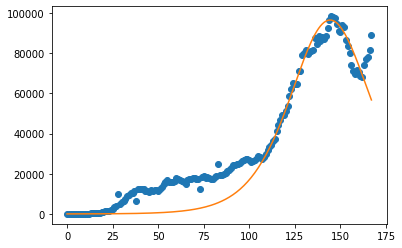

In [98]:
def deriv(t, y, beta, gamma):
    S = -beta * y[0] * y[1] / N
    R = gamma * y[1]
    I = -(S + R)
    return S, I, R

def fit_odeint(x, beta, gamma):
    res = integrate.solve_ivp(fun=deriv, t_span=(0, len(X)), y0=(S0, I0, R0), args=(beta, gamma), t_eval=X)
    return res.y[1]

N = 39250000
I0 = Y[0]
S0 = N - I0
R0 = 0.0

popt, pcov = optimize.curve_fit(fit_odeint, X, Y, bounds = ((0, 0), (1, 1)))
fitted = fit_odeint(X, *popt)
print(popt[0])
print(popt[1])
print(popt[0]/popt[1])


plt.plot(X, Y, 'o')
plt.plot(X, fitted)
plt.show()

In [99]:
res = integrate.solve_ivp(fun=deriv, t_span = (1, len(X) + len(df_prediction.total_cases.dropna())), y0=(S0, I0, R0), args=(popt[0], popt[1]), max_step=1)

<ipython-input-109-267a26f3a59f>:22: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True, which='major', c='w', lw=2, ls='--')


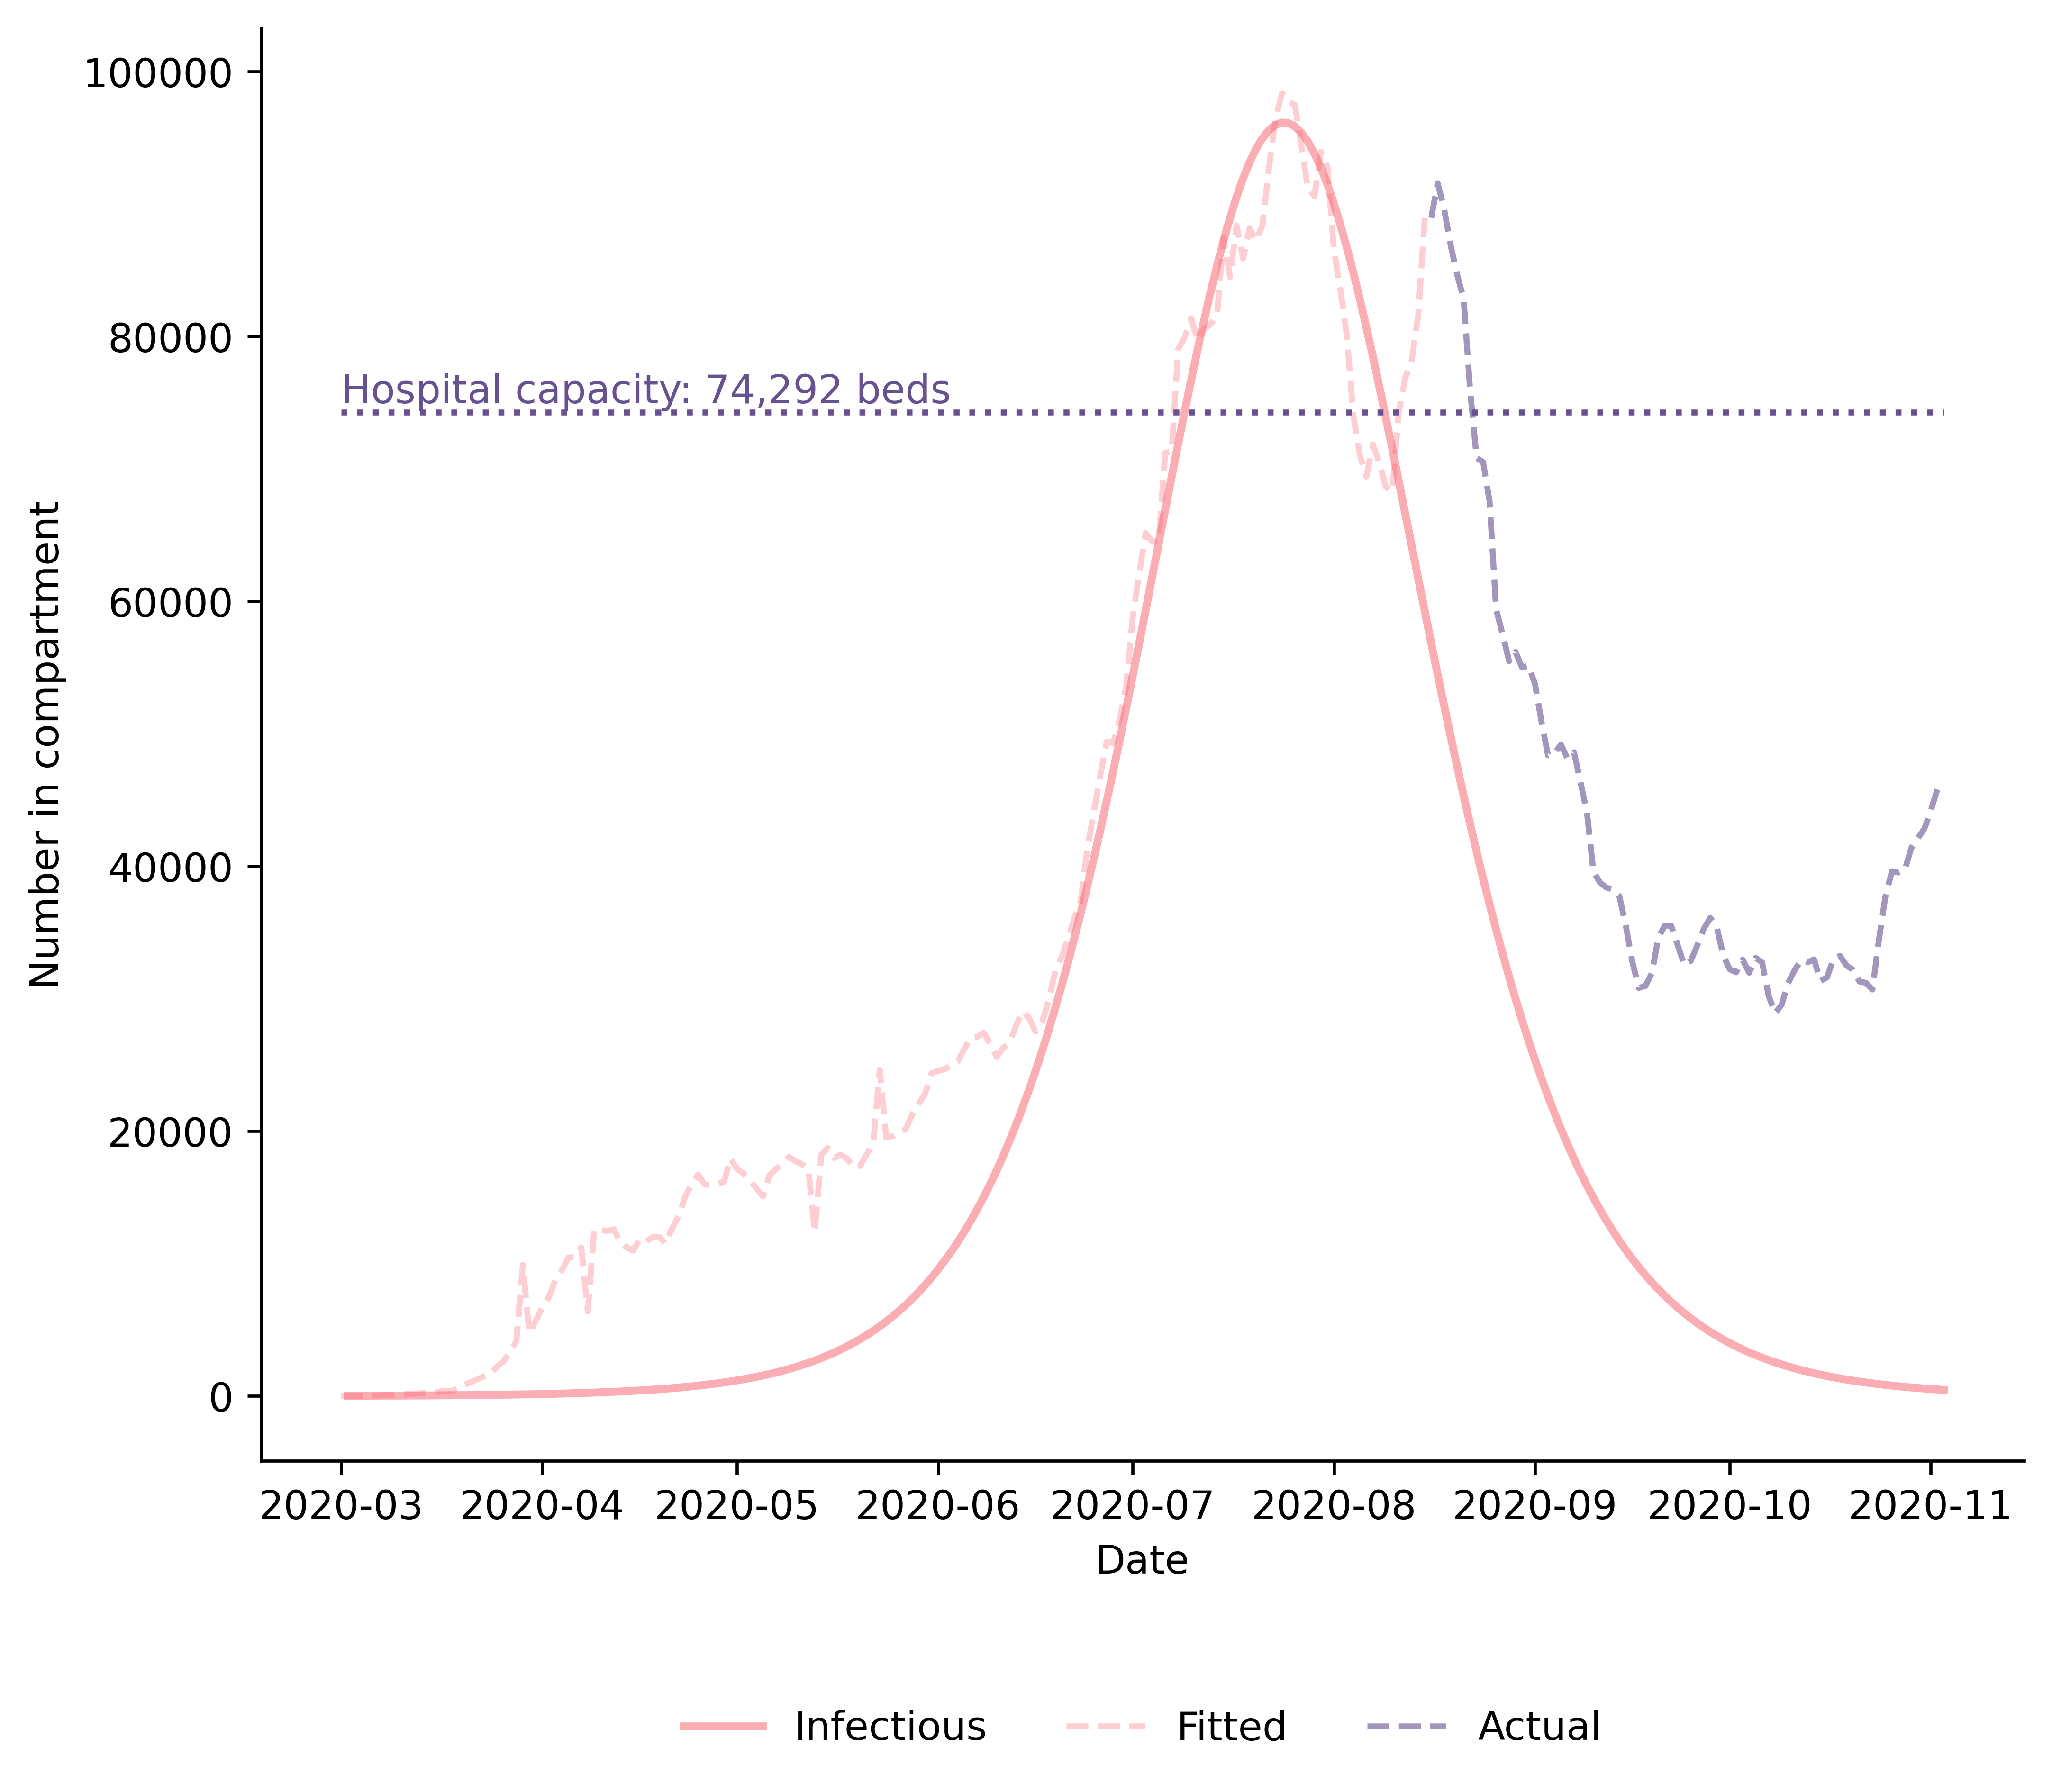

In [109]:
S, I, R = res.y

fig = plt.figure(facecolor="w", figsize=(8, 8), dpi=600)
ax = fig.add_subplot(111, axisbelow=True)



ax.plot(list(map(lambda x: datetime(year=2020, month=3, day=1) + timedelta(days=x), res.t)), 
        I, color=COLORS["I"], alpha=0.5, lw=2, label="Infectious")
ax.plot(list(map(lambda x: datetime(year=2020, month=3, day=1) + timedelta(days=x), X)), 
        Y, color=COLORS["I"], alpha=0.3, ls="--", label="Fitted")
ax.plot(list(map(lambda x: datetime(year=2020, month=3, day=1) + timedelta(days=x), list(range(len(X), len(X) + len(df_prediction.total_cases.dropna()))))), 
        df_prediction.total_cases.dropna(),
        alpha=0.6, 
        ls="--", 
        color=COLORS["X"], label="Actual")


ax.set_xlabel('Date')
ax.set_ylabel("Number in compartment")

ax.grid(b=True, which='major', c='w', lw=2, ls='--')

for spine in ("top", "right"):
    ax.spines[spine].set_visible(False)

legend = ax.legend()
legend.get_frame().set_alpha(0.5)
plt.legend(title='', bbox_to_anchor=(0.5, -0.225), loc="lower center", ncol=3, frameon=False)

fig.subplots_adjust(bottom=0.25)

# Total hospital capacity line (from https://www.ahd.com/states/hospital_CA.html)
ax.hlines(74292, 
          xmin=datetime(year=2020, month=3, day=1) + timedelta(days=X[0]), 
          xmax=datetime(year=2020, month=3, day=1) + timedelta(days=len(X) + len(df_prediction.total_cases.dropna())), 
          linestyles=":", 
          color=COLORS["X"])

ax.annotate(xy=(datetime(year=2020, month=3, day=1) + timedelta(days=X[0]), 75000), 
            text="Hospital capacity: 74,292 beds", 
            color=COLORS["X"])

plt.savefig("fitted_sir.pdf")
plt.show()